In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import contextily as ctx 
import geopandas as gpd 
import os 
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Question 1

In [14]:
#read dataset as df
df = pd.read_csv("NCES_CCD_extract.csv")

## Rename the variables to have sensible names

In [15]:
# Rename for easy use
df1 = df.rename(columns={'Agency Name':'distname',\
                        'State Name [District] Latest available year':'stname', 'State Abbr [District] Latest available year': 'stabbr', \
                         'Agency ID - NCES Assigned [District] Latest available year':'distid', 'Hispanic Students [District] 2019-20':'hisp2019', \
                          'Hispanic Students [District] 2018-19':'hisp2018','Hispanic Students [District] 2017-18':'hisp2017', \
                        'Hispanic Students [District] 2016-17':'hisp2016', 'Hispanic Students [District] 2015-16':'hisp2015', \
                          'Hispanic Students [District] 2014-15':'hisp2014', 'Black or African American Students [District] 2019-20':'black2019', \
                        'Black or African American Students [District] 2018-19':'black2018', 'Black or African American Students [District] 2017-18':'black2017',\
                        'Black or African American Students [District] 2016-17':'black2016', 'Black or African American Students [District] 2015-16':'black2015', 
                        'Black or African American Students [District] 2014-15':'black2014',  'White Students [District] 2019-20':'white2019', \
                         'White Students [District] 2018-19':'white2018', 'White Students [District] 2017-18':'white2017', \
                        'White Students [District] 2016-17':'white2016', 'White Students [District] 2015-16':'white2015', \
                        'White Students [District] 2014-15':'white2014', 'Fall Membership (V33) [District Finance] 2017-18': 'mem2017', \
                        'Fall Membership (V33) [District Finance] 2016-17': 'mem2016', 'Fall Membership (V33) [District Finance] 2015-16': 'mem2015', \
                        'Fall Membership (V33) [District Finance] 2014-15': 'mem2014', 'Total General Revenue (TOTALREV) [District Finance] 2017-18':'totrev2017',\
                        'Total General Revenue (TOTALREV) [District Finance] 2016-17':'totrev2016', 'Total General Revenue (TOTALREV) [District Finance] 2015-16':'totrev2015', \
                        'Total General Revenue (TOTALREV) [District Finance] 2014-15':'totrev2014', 'Total Expenditures (TOTALEXP) [District Finance] 2017-18':'totexp2017', \
                        'Total Expenditures (TOTALEXP) [District Finance] 2016-17':'totexp2016', 'Total Expenditures (TOTALEXP) [District Finance] 2015-16':'totexp2015', \
                        'Total Expenditures (TOTALEXP) [District Finance] 2014-15':'totexp2014'})



## Destring the variables that should be numeric

In [16]:
# Destring the variables that should be numeric
numeric_columns = ['distid','hisp2019', 'hisp2018', 'hisp2017', 'hisp2016', 'hisp2015', 'hisp2014',
                   'black2019', 'black2018', 'black2017', 'black2016', 'black2015', 'black2014',
                   'white2019', 'white2018', 'white2017', 'white2016', 'white2015', 'white2014',
                   'mem2017', 'mem2016', 'mem2015', 'mem2014',
                   'totrev2017', 'totrev2016', 'totrev2015', 'totrev2014',
                   'totexp2017', 'totexp2016', 'totexp2015', 'totexp2014']

# copy the dataframe to df2 for future convenience
df2 = df1.copy()
df2[numeric_columns] = df2[numeric_columns].apply(pd.to_numeric, errors='coerce')

## Drop the missing records in numerical cols

In [17]:
missing_data = df2[numeric_columns].isna()
df3 = df2.dropna(subset=numeric_columns)

## Reshape the data so the unit of observation is the district-year combination

In [18]:
df4 = df3.melt(id_vars=['distid', 'distname', 'stname', 'stabbr'], var_name='name_year')
df4[['name', 'year']] = df4['name_year'].str.extract(r'([A-Za-z]+)([0-9]+)')
df4 = df4.pivot_table(index=['distid', 'distname', 'stname', 'stabbr', 'year'], columns='name', values='value', aggfunc='sum').reset_index()

## Check for the data

In [19]:
def describe_data(data):
    num_observations, num_variables = data.shape
    variable_types = data.dtypes
    print(f"Observations: {num_observations}")
    print(f"Variables: {num_variables}")
    print("\nVariable Storage Display")
    print(f"name\ttype\tformat")

    for variable_name, variable_type in variable_types.items():
        variable_format = ''
        if variable_type == 'int64':
            variable_format = '%10.0g'
        elif variable_type == 'float64':
            variable_format = '%10.0g'
        elif variable_type == 'object':
            variable_format = f'%{max(len(variable_name), 9)}s'
        print(f"{variable_name}\t{variable_type}\t{variable_format}")
        
describe_data(df4)

Observations: 59370
Variables: 11

Variable Storage Display
name	type	format
distid	float64	%10.0g
distname	object	%9s
stname	object	%9s
stabbr	object	%9s
year	object	%9s
black	float64	%10.0g
hisp	float64	%10.0g
mem	float64	%10.0g
totexp	float64	%10.0g
totrev	float64	%10.0g
white	float64	%10.0g


# Question 2

- Per-pupil revenue and per-pupil expenditures

In [20]:
df5 = df4.copy()
df5['pupil_per_rev'] = df4['totrev'] / df4['mem']
df5['pupil_per_exp'] = df4['totexp'] / df4['mem']

- Create log of per pupil revenues and expenditures by taking the log of each respective variable.

In [21]:
df6 = df5.copy()
df6['pupil_per_rev_log'] = np.log1p(df5['pupil_per_rev'])
df6['pupil_per_exp_log'] = np.log1p(df5['pupil_per_exp'])

- Create the share of the student body that is either Black or Hispanic by adding Black and Hispanic enrollments together and dividing by total membership.

In [22]:
df7 = df6.copy()
df7['black_hisp_total'] = df7['black'] + df7['hisp']
df7['black_hisp_share'] = df7['black_hisp_total'] / df7['mem']

# Question 3

- Visualize the correlation between Black/Hispanic enrollment share and log of total revenues and log of total expenditures.

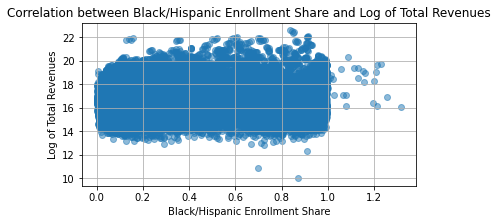

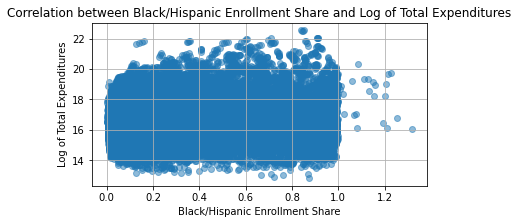

In [23]:
df8 = df7.copy()
df8['totrev_log'] = np.log1p(df8['totrev'])
df8['totexp_log'] = np.log1p(df8['totexp'])

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
plt.scatter(df8['black_hisp_share'], df8['totrev_log'], alpha=0.5)
plt.title('Correlation between Black/Hispanic Enrollment Share and Log of Total Revenues')
plt.xlabel('Black/Hispanic Enrollment Share')
plt.ylabel('Log of Total Revenues')
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(df8['black_hisp_share'], df8['totexp_log'], alpha=0.5)
plt.title('Correlation between Black/Hispanic Enrollment Share and Log of Total Expenditures')
plt.xlabel('Black/Hispanic Enrollment Share')
plt.ylabel('Log of Total Expenditures')
plt.grid(True)
plt.show()


# Question 4

In a single figure, plot both the average log of total per pupil revenue and log of total
per pupil expenditures against the share of Black/Hispanic student quantiles.

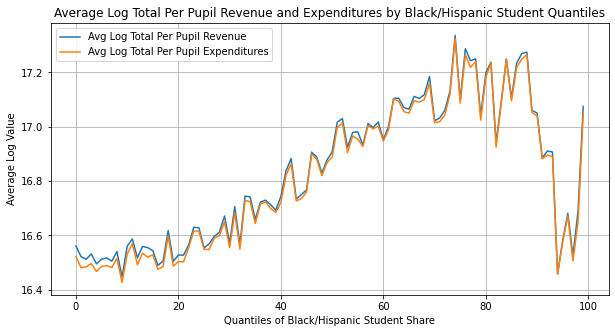

In [26]:
df9=df8.copy()
df9['quantile'] = pd.qcut(df9['black_hisp_share'], q=100, labels=False)
quantile_stats = df9.groupby('quantile').agg({
    'totrev_log': 'mean',
    'totexp_log': 'mean'
}).reset_index()
quantile_stats_array = quantile_stats.to_numpy()

plt.figure(figsize=(10, 5))
plt.plot(quantile_stats_array[:, 0], quantile_stats_array[:, 1], label='Avg Log Total Per Pupil Revenue')
plt.plot(quantile_stats_array[:, 0], quantile_stats_array[:, 2], label='Avg Log Total Per Pupil Expenditures')
plt.title('Average Log Total Per Pupil Revenue and Expenditures by Black/Hispanic Student Quantiles')
plt.xlabel('Quantiles of Black/Hispanic Student Share')
plt.ylabel('Average Log Value')
plt.legend()
plt.grid(True)
plt.show()

- In a single figure, plot both the average log of total per pupil revenue and log of total
per pupil expenditures against the share of Black/Hispanic student quantiles. What
patterns emerge?

- Answer: The per pupil expenditure and expenditures have positive correlation with black/hispanic student share, as the black/hispanic share goes high, the expenditures and revenues going up as well."

# Question 5

- Plot the state average total per-pupil expenditures against the state average Black/Hispanic enrollment share and label each point with the corresponding state two-letter abbreviation.

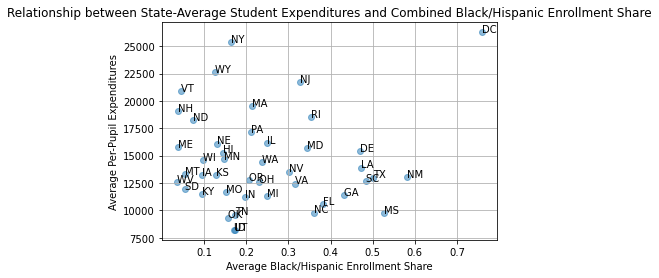

In [29]:
# Group the data by state (stabbr)
state_groups = df9.groupby('stabbr')

# Calculate the average Black/Hispanic share and per-pupil expenditures for each state
state_summary = state_groups.agg({
    'black': 'mean',
    'hisp': 'mean',
    'black_hisp_share':'mean',
    'pupil_per_exp': 'mean'
}).reset_index()

# Rename the columns if needed
state_summary.rename(columns={'black_hisp_share': 'Avg_black_hist_Share', 'pupil_per_exp': 'Avg_Per_Pupil_Exp'}, inplace=True)

# Plot the scatter plot with the x-axis as the combined avg Black/Hispanic share and the y-axis as the average per-pupil expenditures
plt.scatter(state_summary['Avg_black_hist_Share'], state_summary['Avg_Per_Pupil_Exp'], alpha=0.5)

# Add labels with two-letter state abbreviations
for i, txt in enumerate(state_summary['stabbr']):
    plt.annotate(txt, (state_summary['Avg_black_hist_Share'].iloc[i], state_summary['Avg_Per_Pupil_Exp'].iloc[i]))

# Add axis labels and a title
plt.xlabel('Average Black/Hispanic Enrollment Share')
plt.ylabel('Average Per-Pupil Expenditures')
plt.title('Relationship between State-Average Student Expenditures and Combined Black/Hispanic Enrollment Share')

# Display the plot
plt.grid(True)  

# Question 6

## Make an amazing cloropleth map

- Example 1 for US state map visualization

In [23]:
# Get stats
# Retrive the official shapefiles maps from the US Census Bureau 
# link: https://www.census.gov/cgi-bin/geo/shapefiles/index.php
path = "tl_2022_us_state/tl_2022_us_state.shp"
gdf = gpd.read_file(path)
gdf = gdf.to_crs("EPSG:4326")

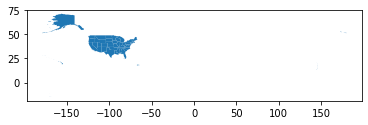

In [24]:
# basic plot
gdf.plot()

In [25]:
# removal of non_continetal states for better visualization
non_continental = ['HI','VI','MP','GU','AK','AS','PR']
us49 = gdf
for n in non_continental:
    us49 = us49[us49.STUSPS != n]

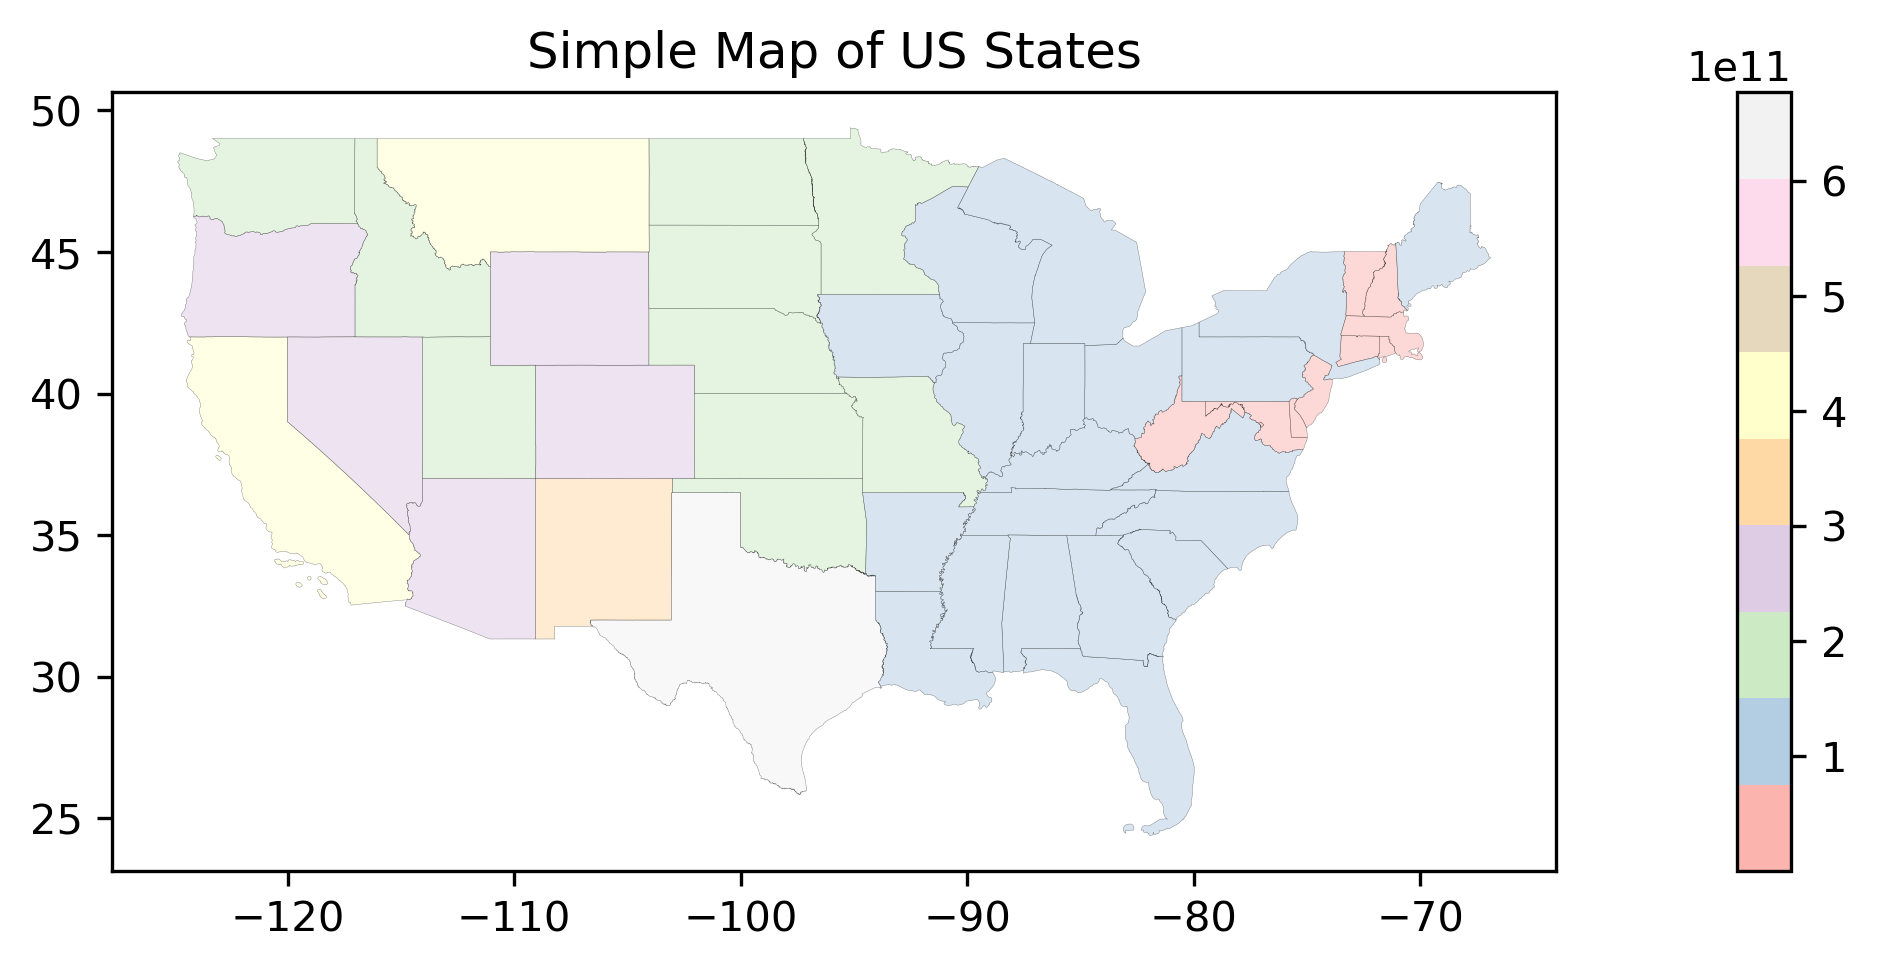

In [26]:
# Simple map for US States based on the downloaded file
f,ax = plt.subplots(1,1, figsize=(8,6), sharex=True, sharey=True, dpi=300)
plt.title('Simple Map of US States')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%",pad=0,alpha=0.5)
us49.plot('ALAND', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, cax=cax, linewidth=0.1)
plt.show()

- Example 2 for the combination of the data we have processed with the States data with geo information

In [34]:
# Starting combine the data we have processed with the States data with geo information
# Combine the data with geo information
my_data = state_summary[['stabbr', 'Avg_black_hist_Share']]
merged = us49.merge(my_data, left_on='STUSPS', right_on='stabbr', how='inner')

# Filter out non-continental states
non_continental = ['HI', 'VI', 'MP', 'GU', 'AK', 'AS', 'PR']
merged = merged[~merged['STUSPS'].isin(non_continental)]

# Handle missing values in the specified column (e.g., 'Avg_black_hist_Share')
# Replace NaN values with a default value (e.g., 0)
column_to_plot = 'Avg_black_hist_Share'
default_value = 0
merged[column_to_plot].fillna(default_value, inplace=True) 

# Remove leading/trailing whitespaces and convert to uppercase
us49['STUSPS'] = us49['STUSPS'].str.strip().str.upper()
my_data['stabbr'] = my_data['stabbr'].str.strip().str.upper()

# Perform an inner join
df_join = us49.merge(my_data, left_on='STUSPS', right_on='stabbr', how='inner')

<ipython-input-34-9c23ba090eaa>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_data['stabbr'] = my_data['stabbr'].str.strip().str.upper()


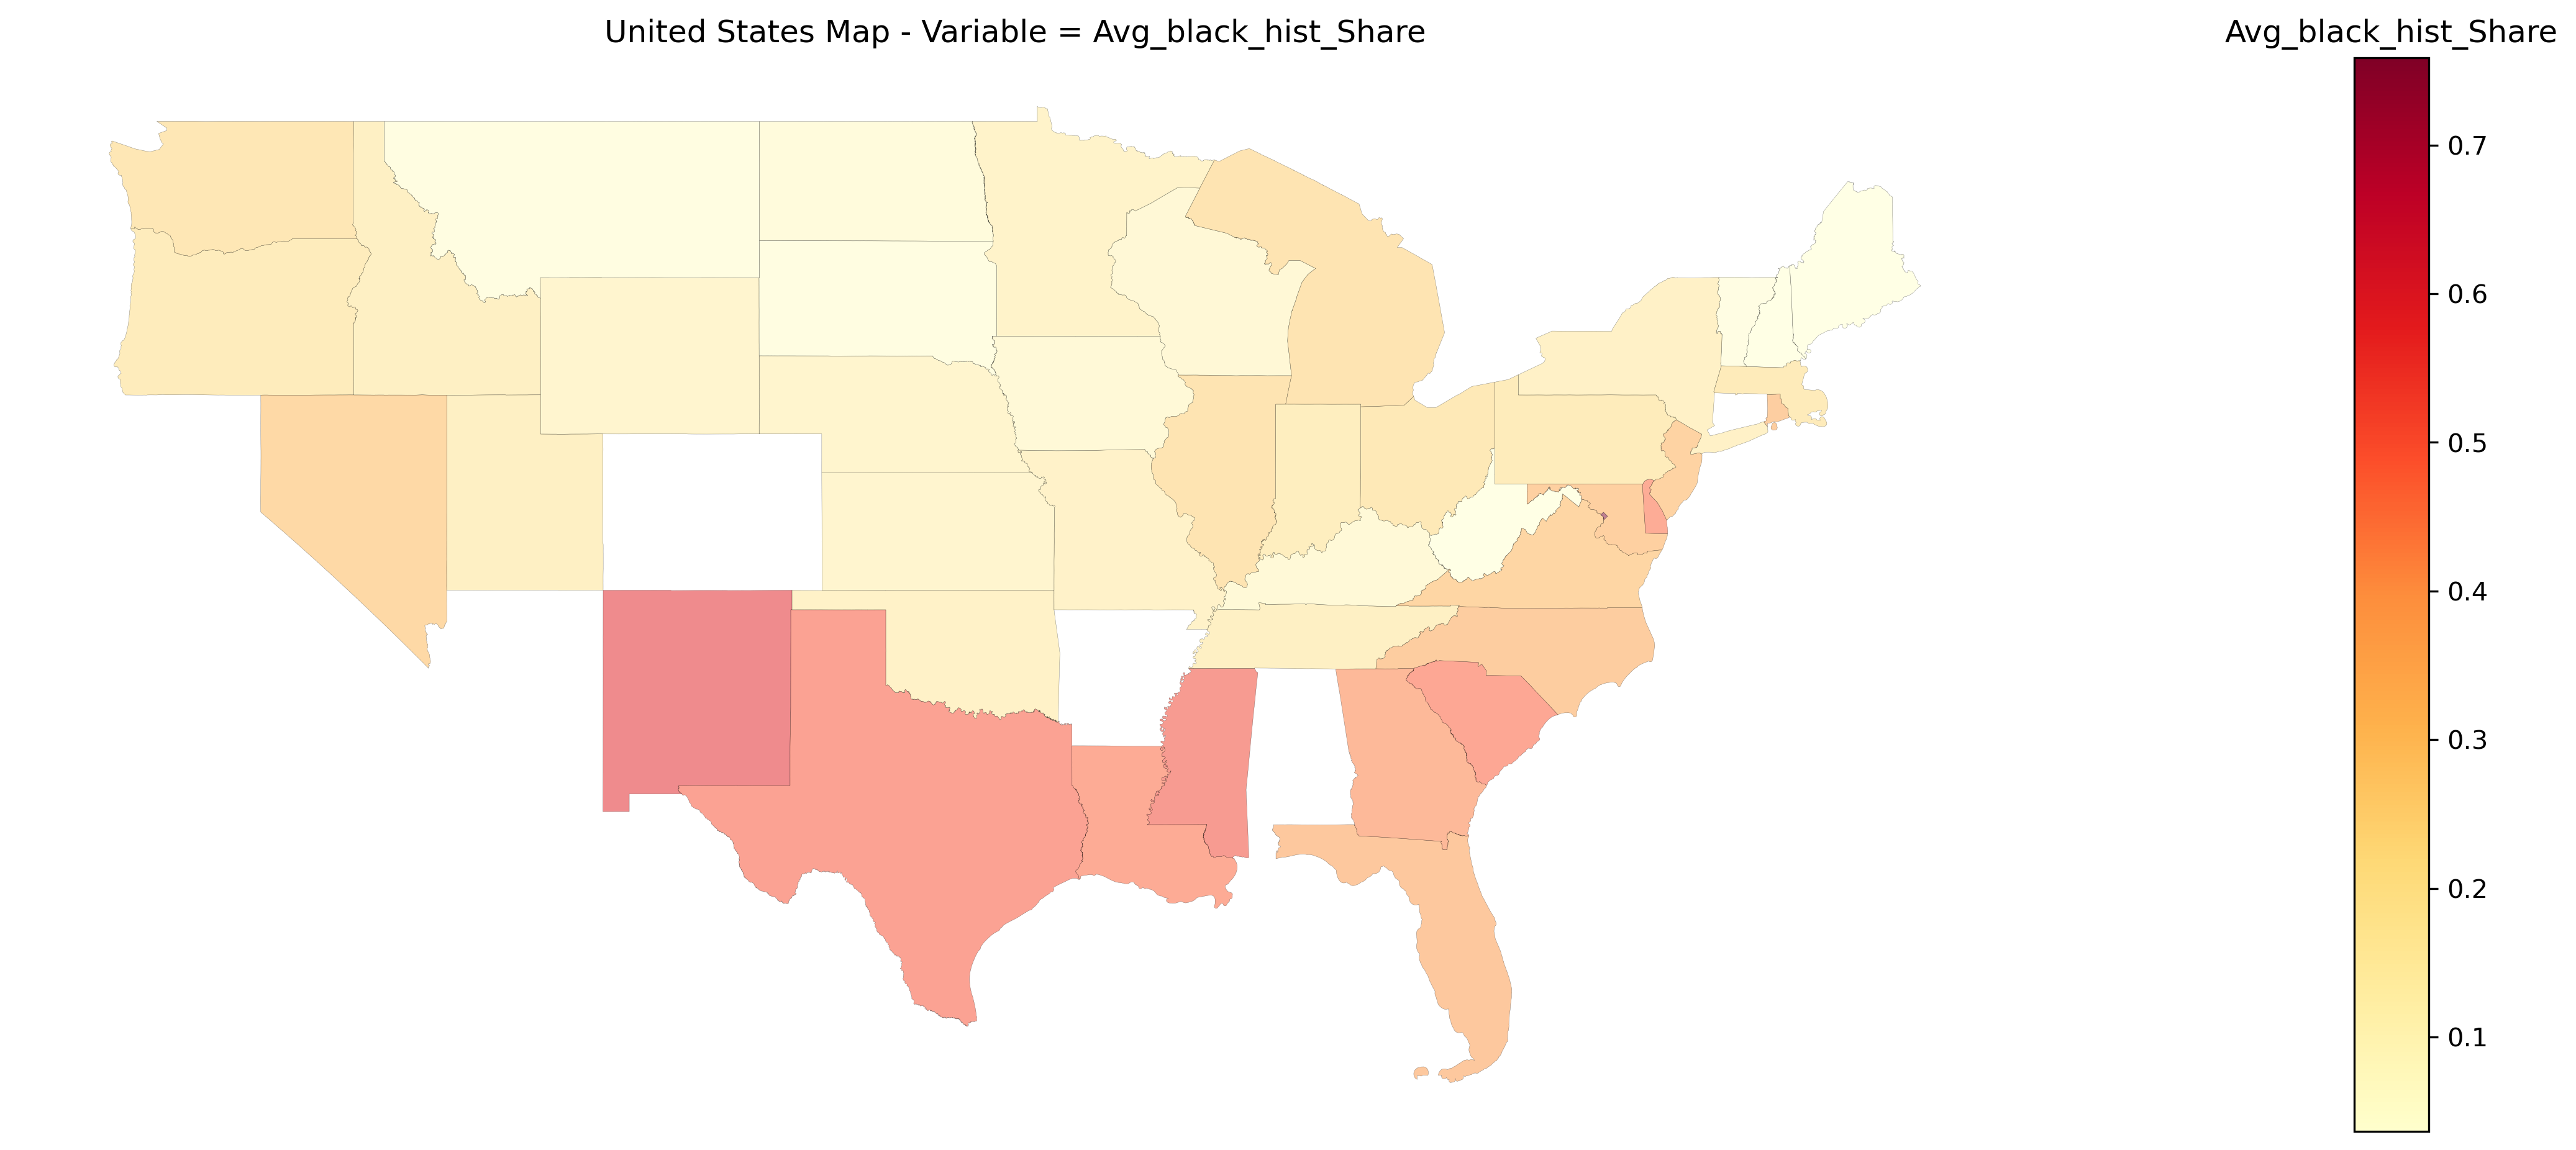

In [35]:
def StatesPlot(df, data, cmap):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharex=True, sharey=True, dpi=300)
    fig.tight_layout()
    plt.title('United States Map - Variable = ' + data)
    ax.set_axis_off()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.5, alpha=0.5)
    
    # Plot the data using the specified colormap
    df.plot(data, ax=ax, alpha=0.5, cmap=cmap, edgecolor='k', legend=True, cax=cax, linewidth=0.1)
    
    # Customize the colorbar label and appearance
    cax.set_title(data, fontsize=12)
    
    plt.show()

# Example usage with df_join:
StatesPlot(df_join, 'Avg_black_hist_Share', 'YlOrRd')

## Make a street map

- Example 1, using data from OpenNYC

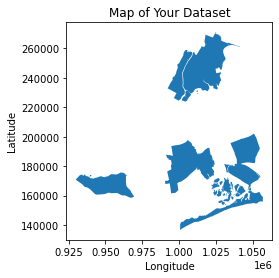

In [41]:
# Specify the name that is used to seach for the data
import geopandas as gpd
import matplotlib.pyplot as plt

shapefile_path = 'Green_Cart_Bnd_2008_DOHMH_2010/Green_Cart_Bnd_2008_DOHMH_2010.shp'

gdf_states_ny = gpd.read_file(shapefile_path)

# gdf_states_ny.head()
gdf_states_ny.plot()
plt.title('Map of Your Dataset')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

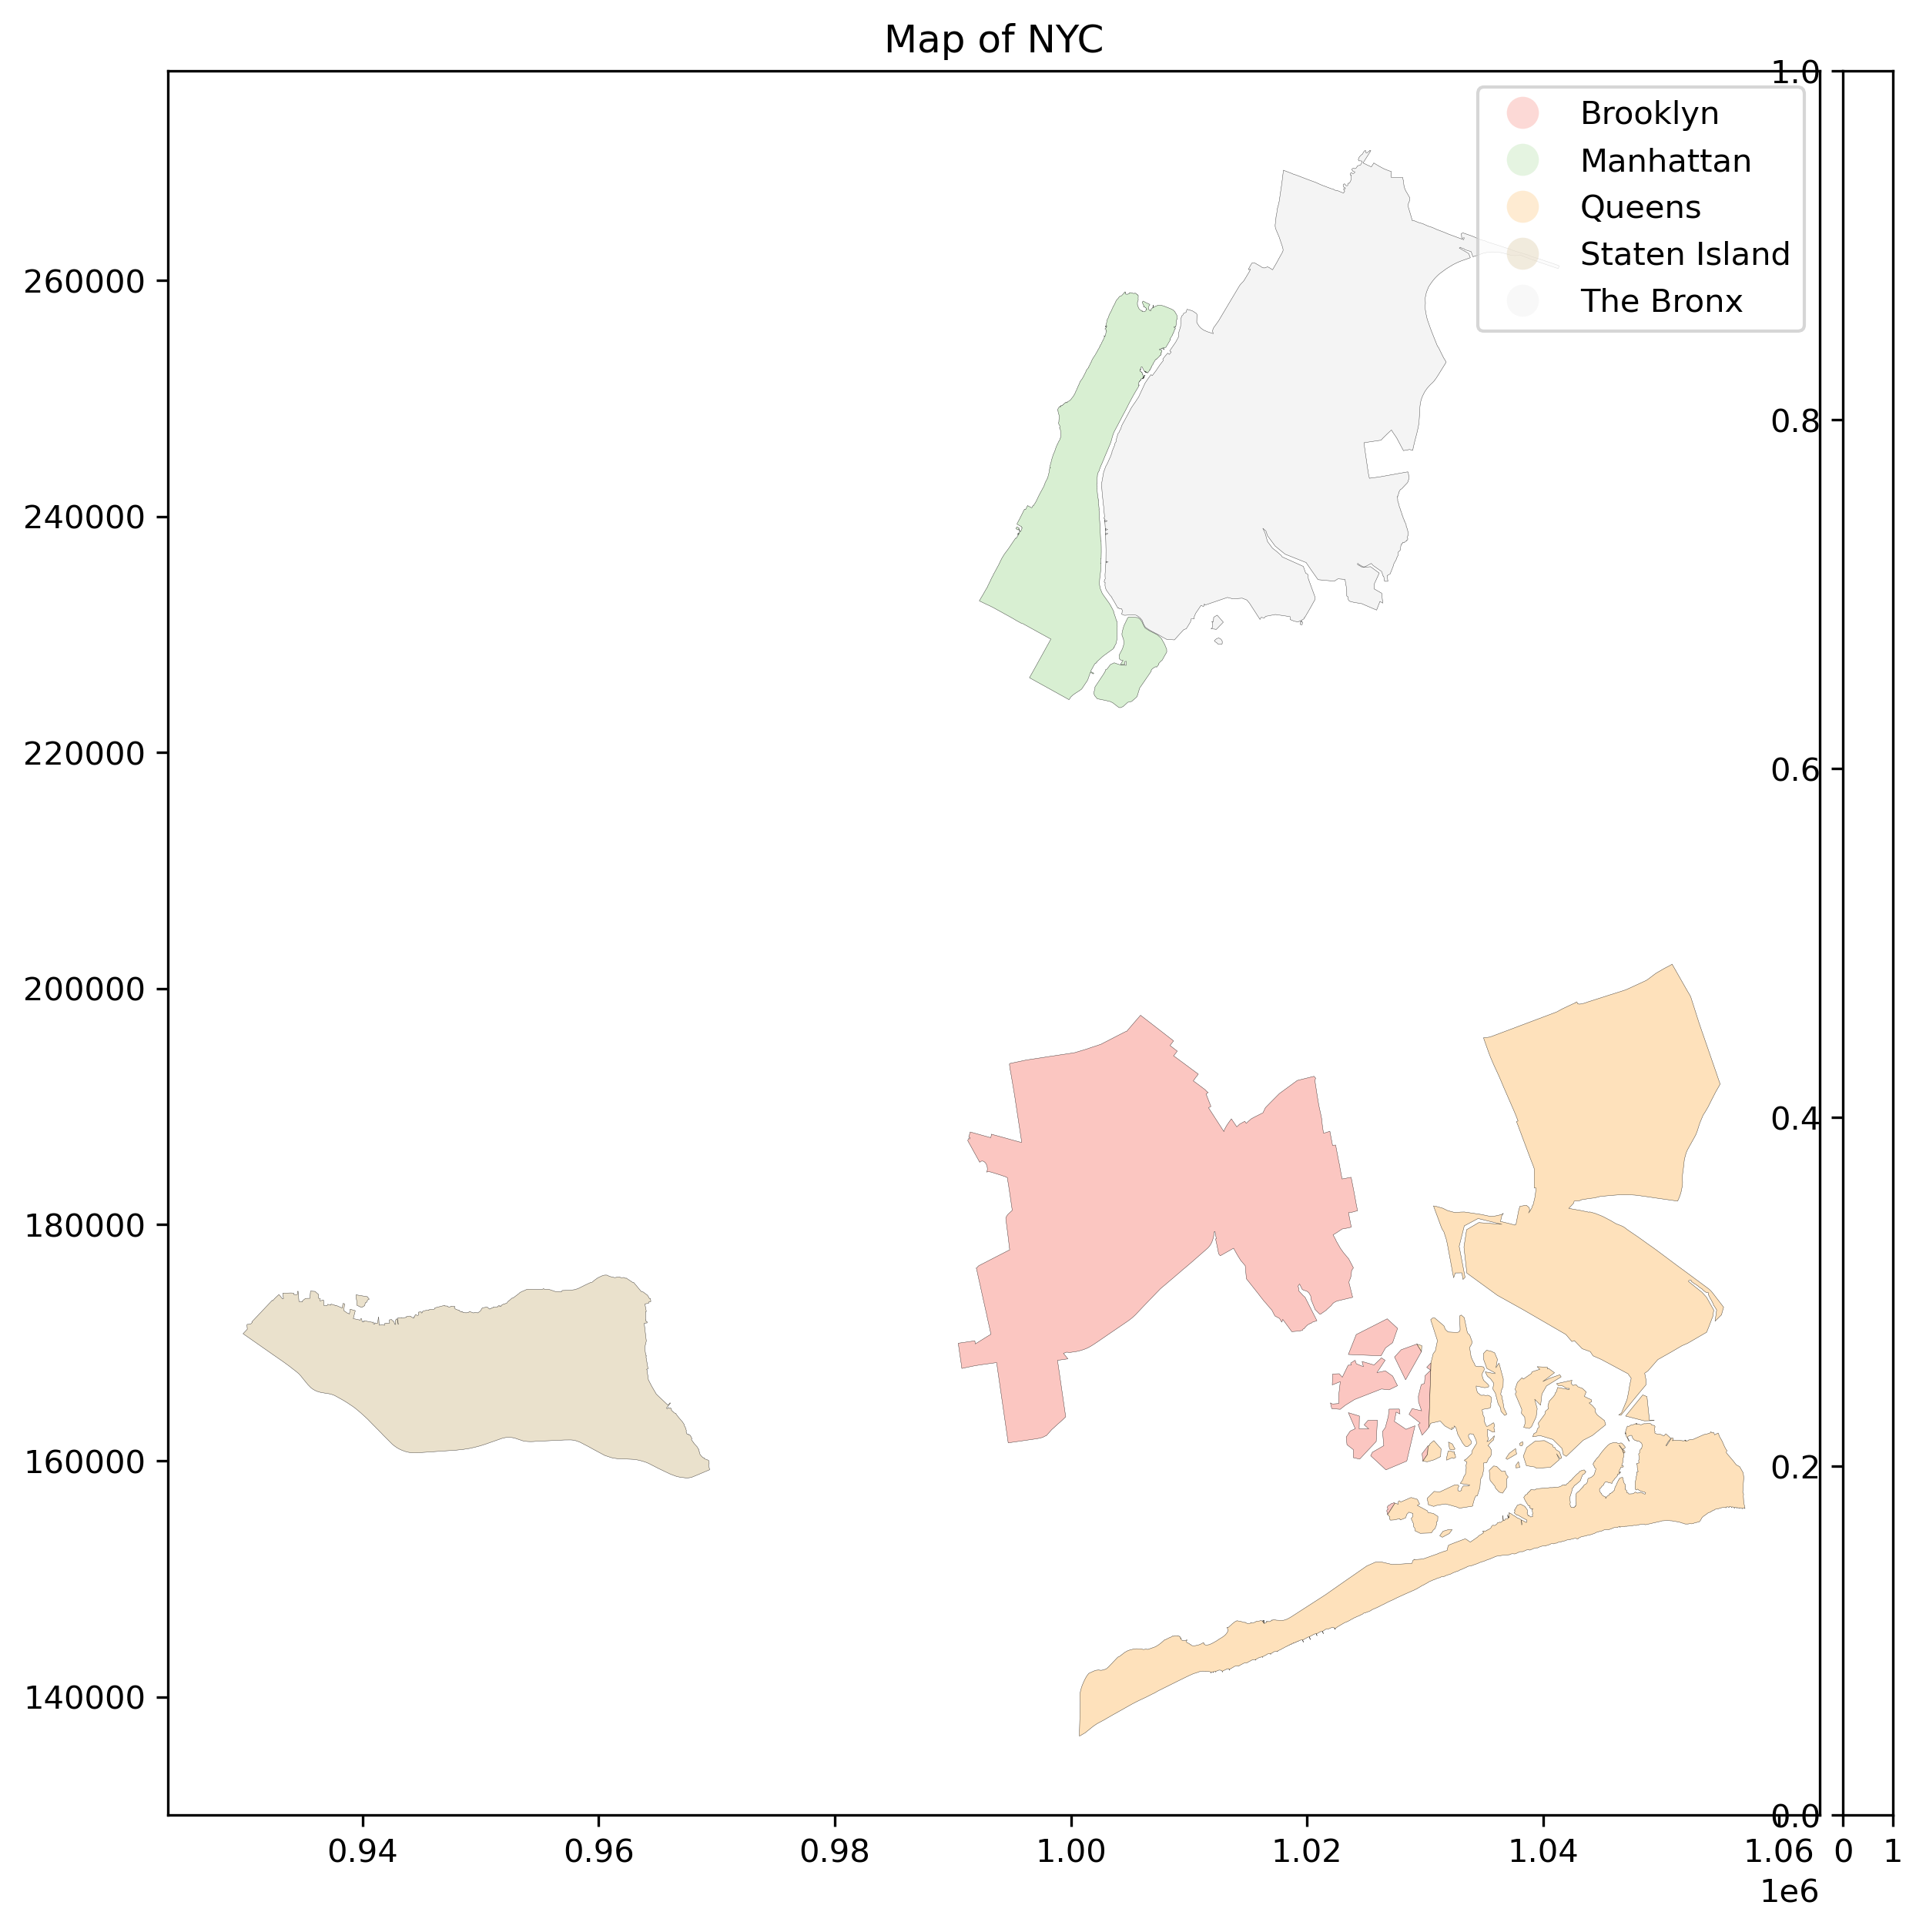

In [42]:
# Map of NYC
f, ax = plt.subplots(1, 1, figsize=(12, 10), sharex=True, sharey=True, dpi=300)
gdf_states_ny.plot('FIRST_BO_1', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, linewidth=0.1)
plt.title('Map of NYC')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

gdf_states_ny.plot('FIRST_BO_1', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', cax=cax, linewidth=0.1)
plt.show()


- Example 2 - using data from the official shapefiles maps from the US Census Bureau (same offical web to download the US states data), this time select Block group -> Select Utah
- link: https://www.census.gov/cgi-bin/geo/shapefiles/index.php

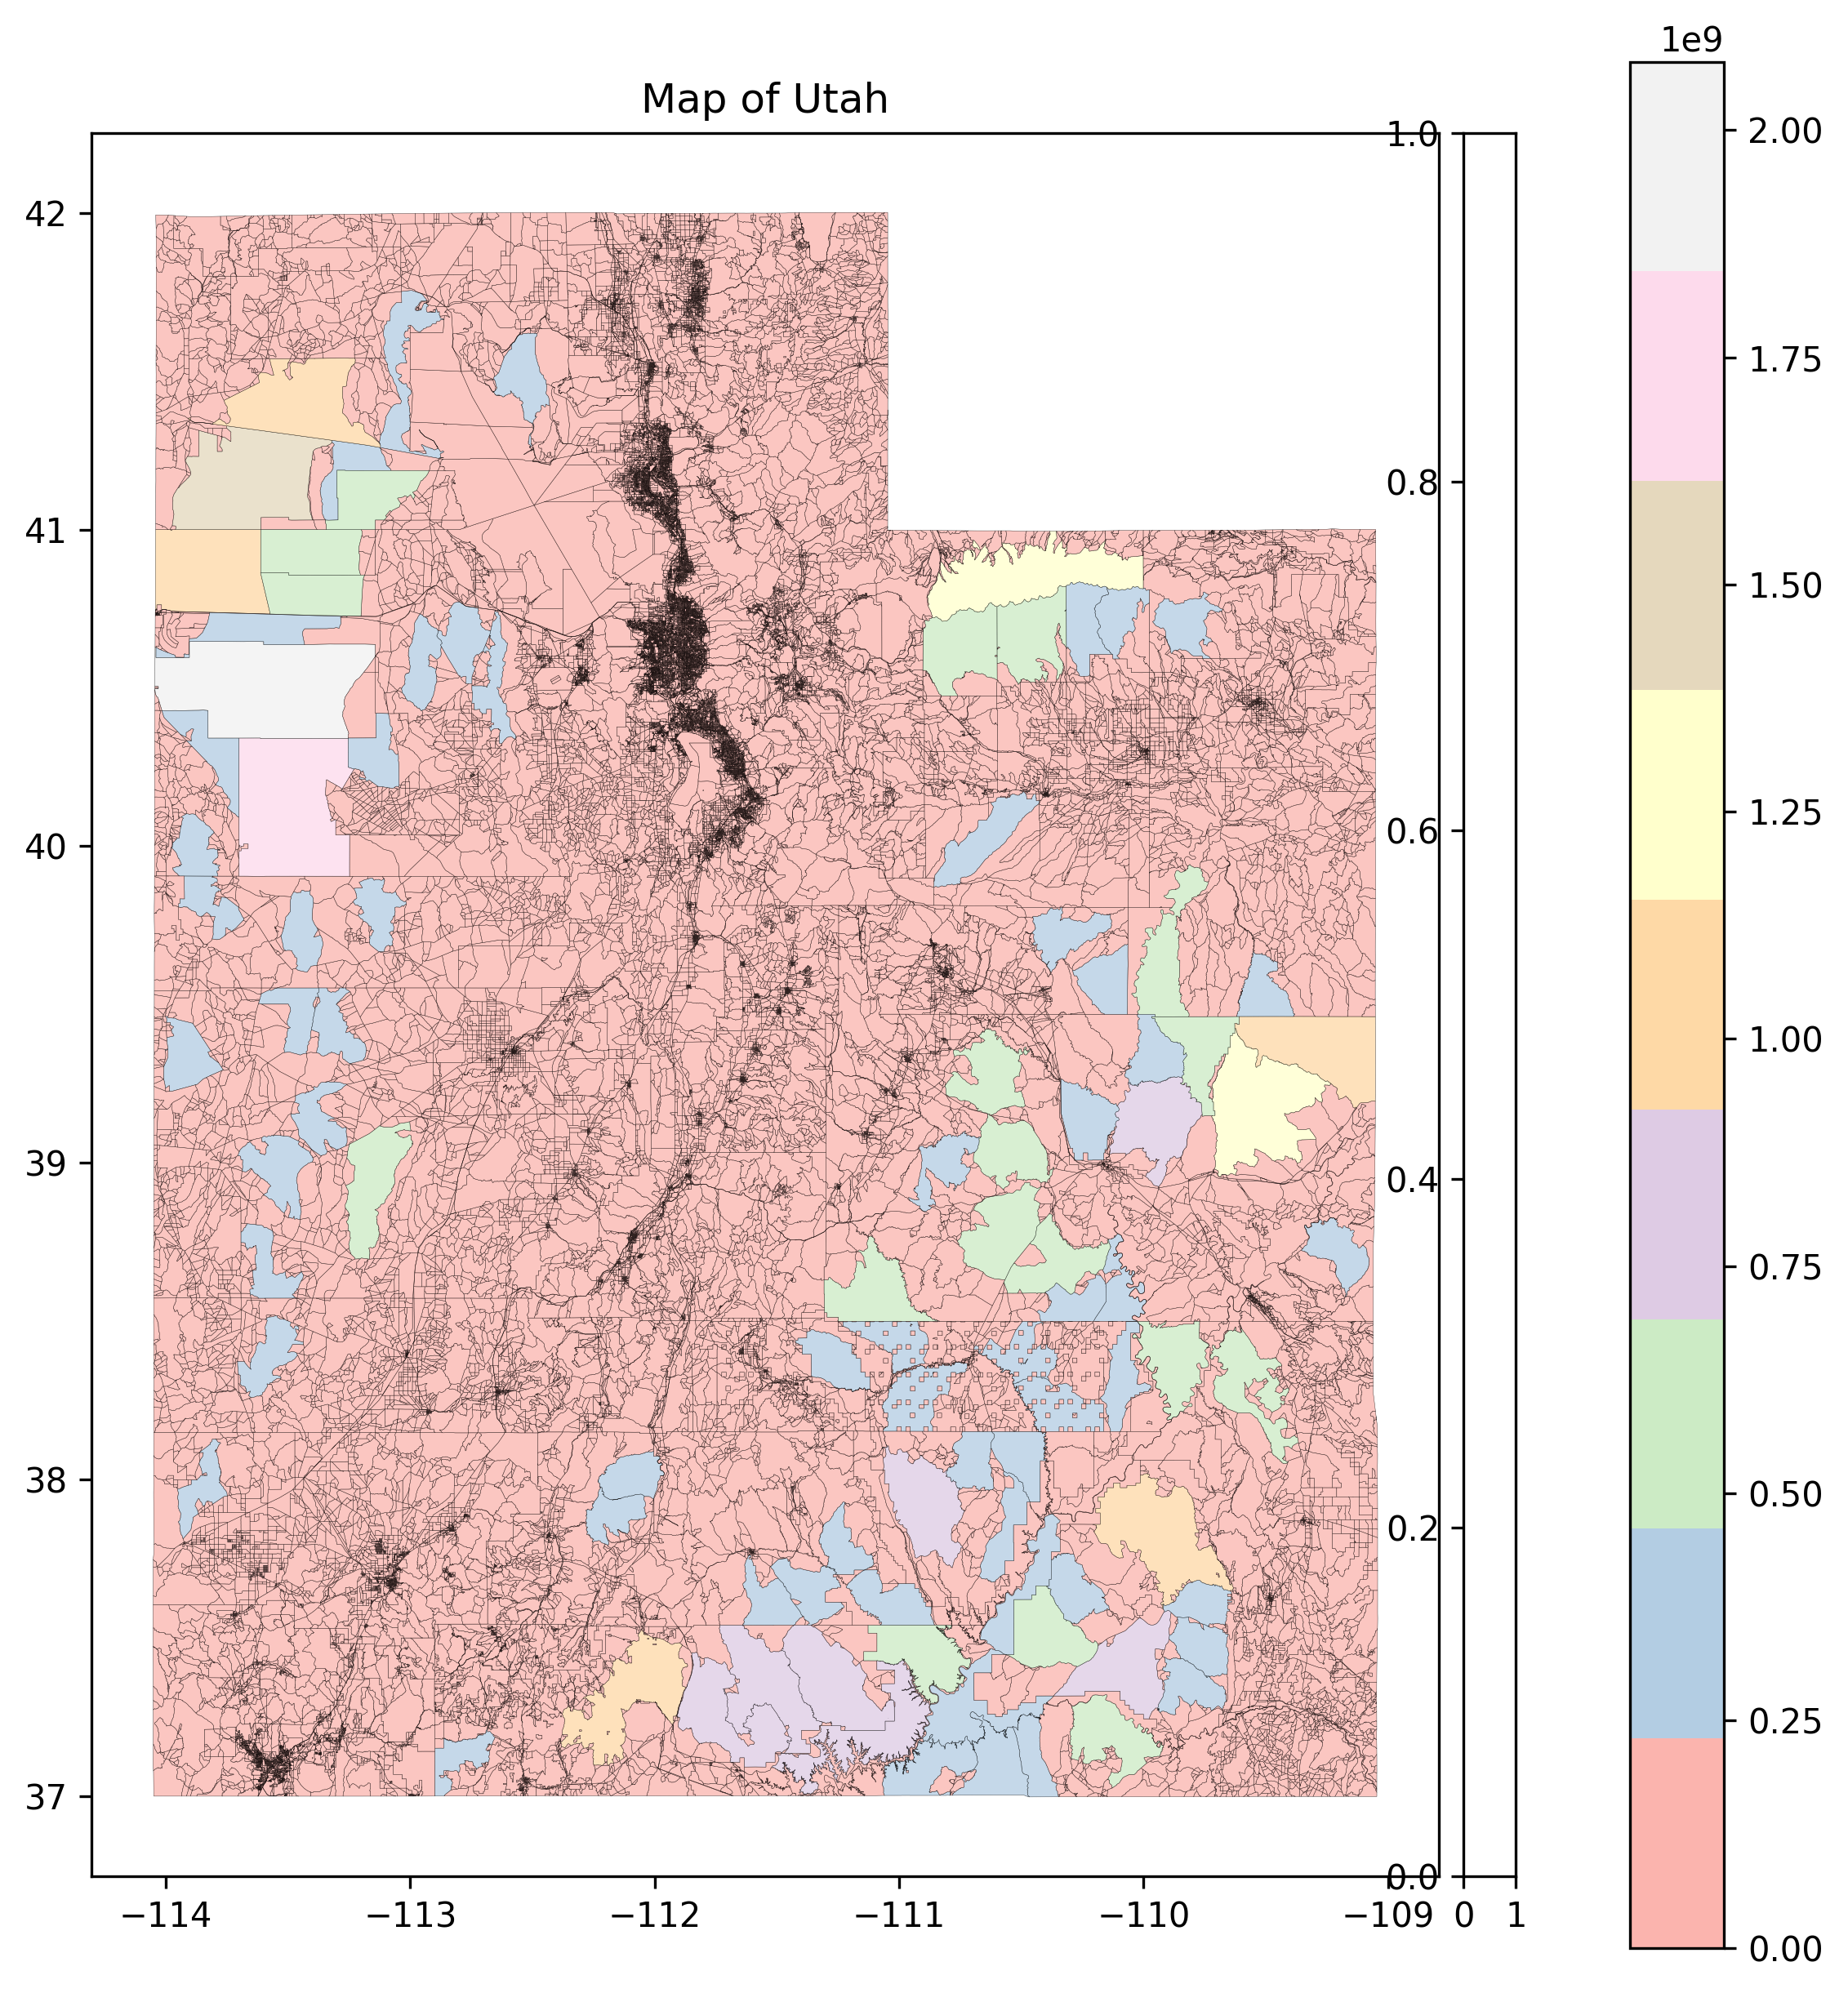

In [3]:

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

shapefile_path = 'tl_2022_49_tabblock20/tl_2022_49_tabblock20.shp'
gdf_states_ut = gpd.read_file(shapefile_path)

f, ax = plt.subplots(1, 1, figsize=(12, 10), sharex=True, sharey=True, dpi=300)
gdf_states_ut.plot('ALAND20', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', legend=True, linewidth=0.1)
plt.title('Map of Utah')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1)

gdf_states_ut.plot('ALAND20', ax=ax, alpha=0.5, cmap='Pastel1', edgecolor='k', cax=cax, linewidth=0.1)
plt.show()

- Using Open Street Map API for further visualization

In [5]:
# Specify the name that is used to search for the geo information of the data
place_name = "Salt Lake City, Utah, USA"
# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)

# List key-value pairs for tags
tags = {'building': True}   
buildings = ox.geometries_from_place(place_name, tags)

/var/folders/q5/_56gtjhj19s4q7xtbc4g0chc0000gn/T/ipykernel_21641/2519948070.py:9: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  buildings = ox.geometries_from_place(place_name, tags)


<Axes: >

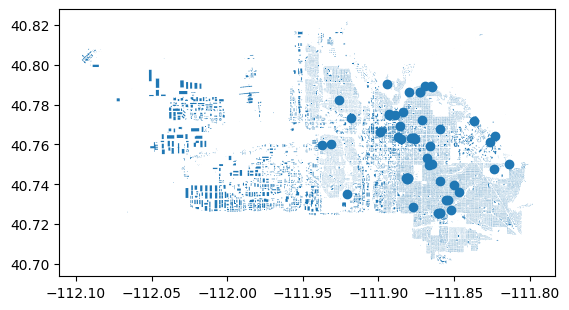

In [30]:
# Plot footprints 
buildings.plot()